In [2]:
import cv2
import numpy as np

In [3]:
from IPython.display import display, Image

def display_cv_image(image, format='.png'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(Image(data=decoded_bytes))

In [4]:
def fit_size(img, h, w):
    size = img.shape[:2]
    f = min(h / size[0], w / size[1])
    return cv2.resize(img, (int(size[1] * f), int(size[0] * f)), interpolation=cv2.INTER_AREA)

In [5]:
import glob
files = glob.glob('images/manual_trim/*')
raw_imgs = [cv2.imread(f) for f in files]
imgs = [fit_size(img, 500, 500) for img in raw_imgs]

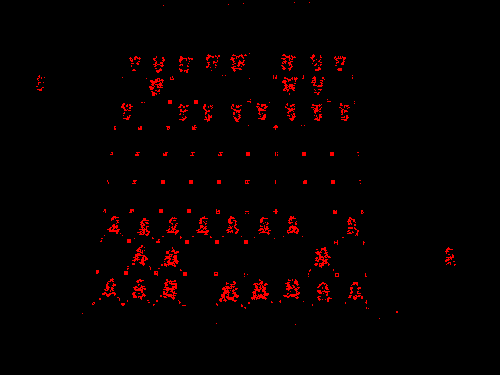

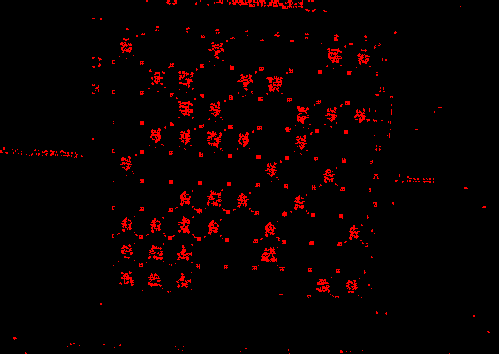

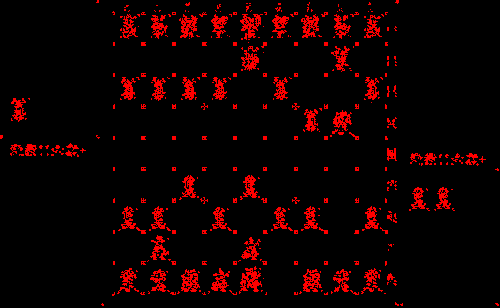

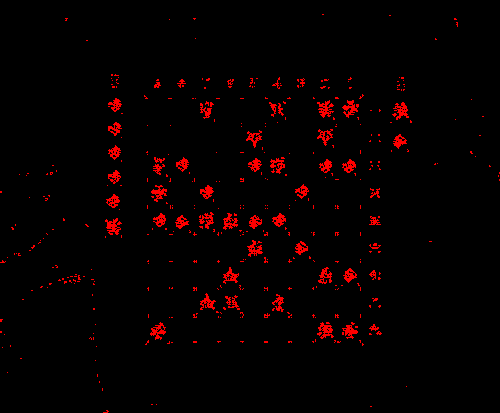

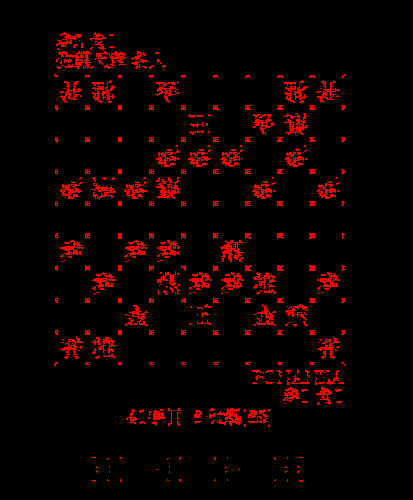

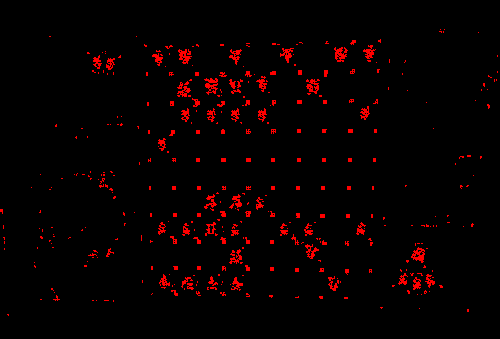

In [6]:
def corner(img, show=True):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    corners = cv2.cornerHarris(gray, 2, 3, 0.04)
    dot_img = np.copy(img)
    dot_img[corners > 0.01 * corners.max()] = [0, 0, 255]

    blank = np.zeros(img.shape, np.uint8)
    blank[corners > 0.01 * corners.max()] = [0, 0, 255]
    if show:
        display_cv_image(blank)
    return corners

for img in imgs:
    corner(img)

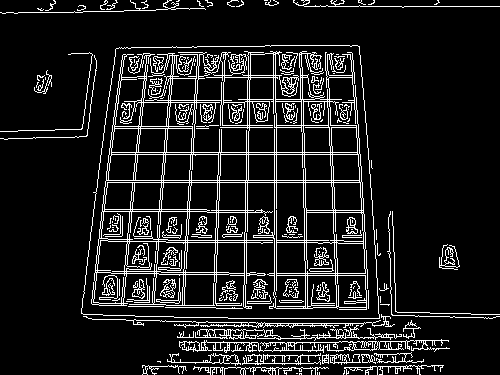

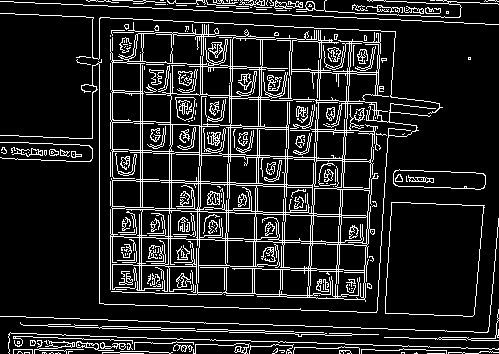

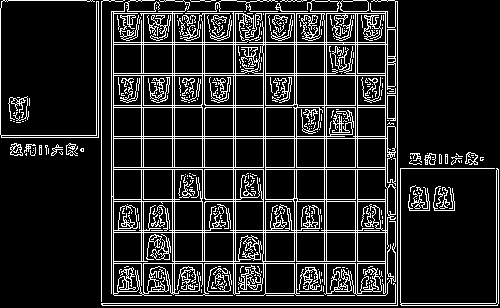

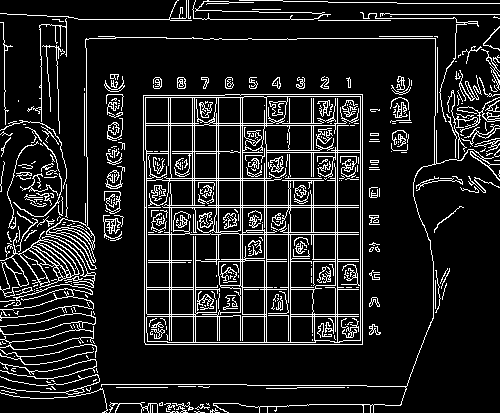

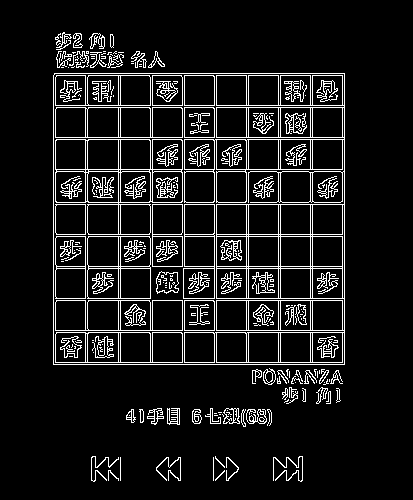

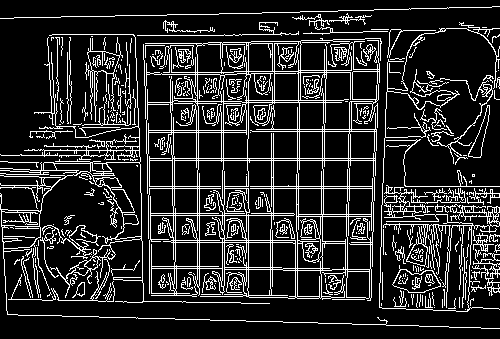

In [6]:
def edge(img, show=True):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    if show:
        display_cv_image(edges)
    return edges

for img in imgs:
    edge(img)

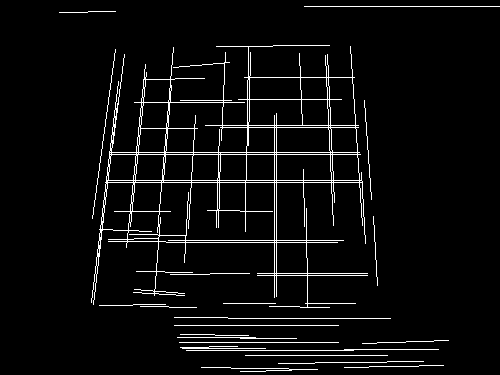

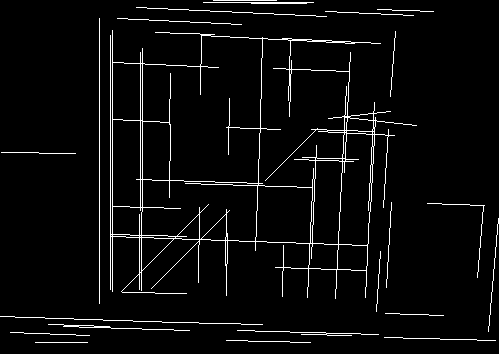

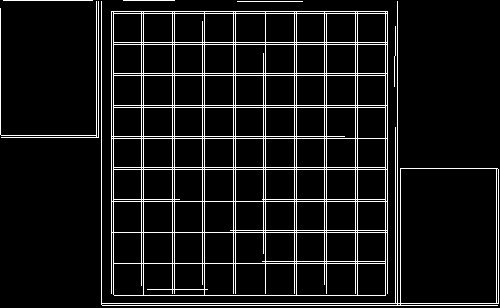

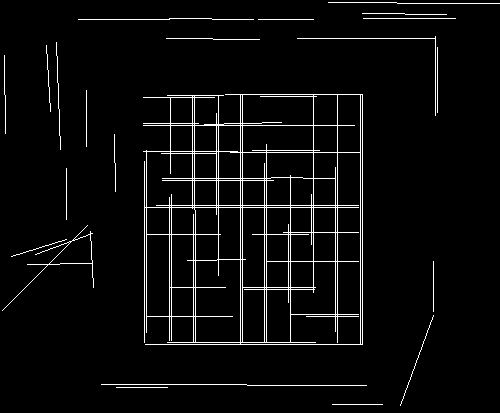

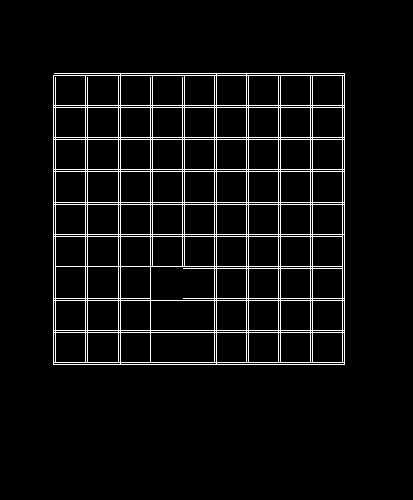

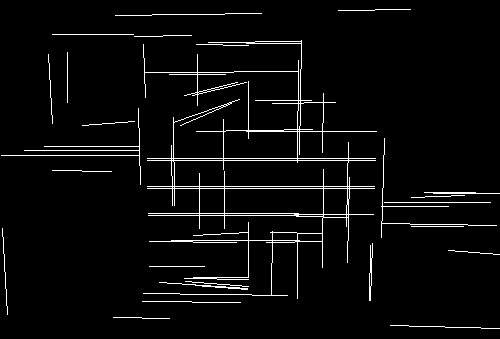

In [7]:
def line(img, show=True, threshold=80, minLineLength=50, maxLineGap=5):
    edges = edge(img, False)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold, 200, minLineLength, maxLineGap)
    if show:
        blank = np.zeros(img.shape, np.uint8)
        for x1, y1, x2, y2 in lines[:, 0]:
            cv2.line(blank, (x1, y1), (x2, y2), (255, 255, 255), 1)
        display_cv_image(blank)
    return lines

for img in imgs:
    line(img)

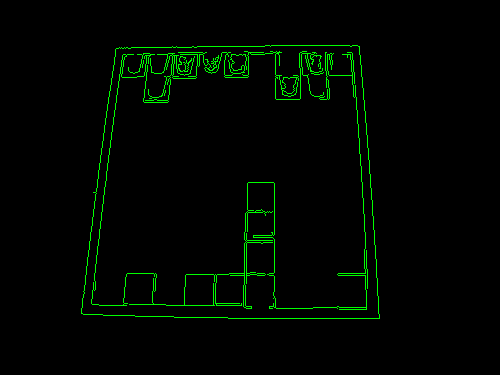

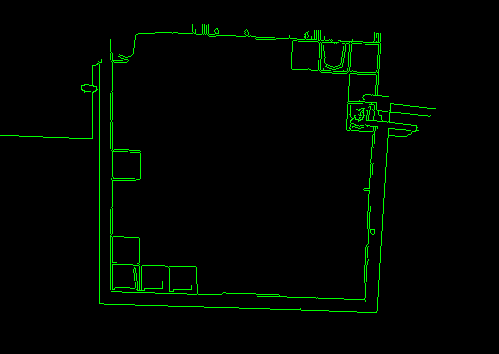

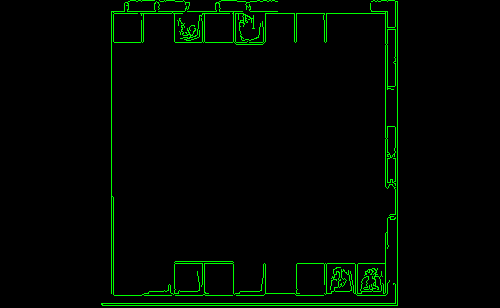

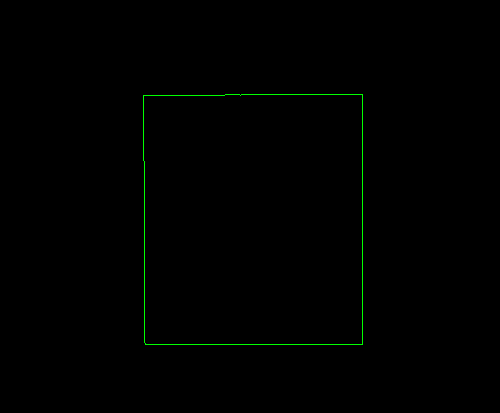

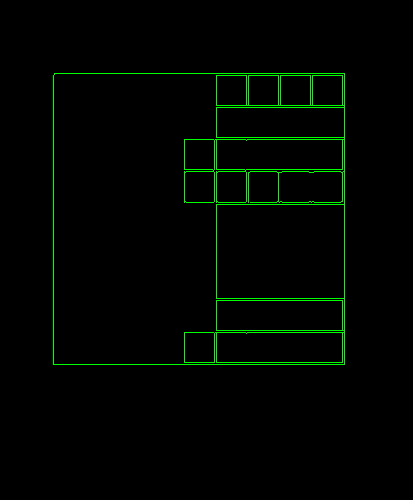

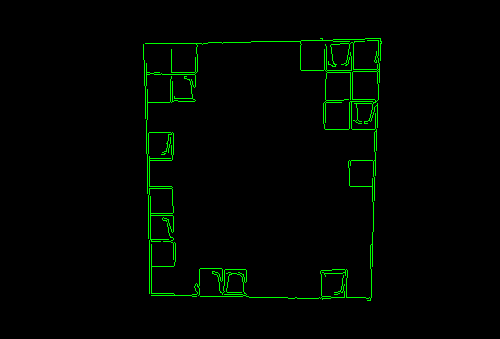

In [8]:
def contours(img, show=True):
    edges = edge(img, False)
    contours = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]
    blank = np.zeros(img.shape, np.uint8)
    min_area = img.shape[0] * img.shape[1] * 0.2 # 画像の何割占めるか
    large_contours = [c for c in contours if cv2.contourArea(c) > min_area]
    cv2.drawContours(blank, large_contours, -1, (0,255,0), 1)
    if show:
        display_cv_image(blank)
    return large_contours

for img in imgs:
    contours(img)

In [9]:
def poly(img, show=True):
    blank = np.copy(img)
    for cnt in contours(img, False):
        arclen = cv2.arcLength(cnt, True)
        poly = cv2.approxPolyDP(cnt, 0.02*arclen, True)
        cv2.drawContours(blank, [poly], -1, (0,255,0), 2)
    if show:
        display_cv_image(blank)

# for img in imgs:
#     poly(img)

In [10]:
def convex(img, show=True):
    blank = np.copy(img)
    convexes = []
    for cnt in contours(img, False):
        convex = cv2.convexHull(cnt)
        cv2.drawContours(blank, [convex], -1, (0,255,0), 2)
        convexes.append(convex)
    if show:
        display_cv_image(blank)
    return convexes

# for img in imgs:
#     convex(img)

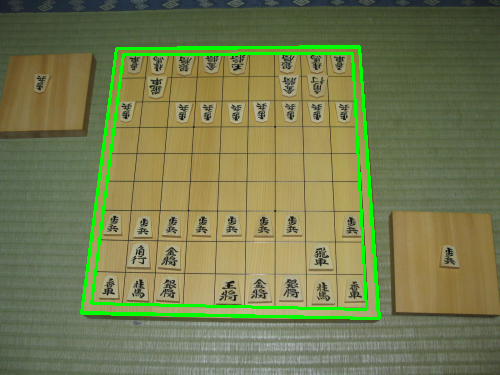

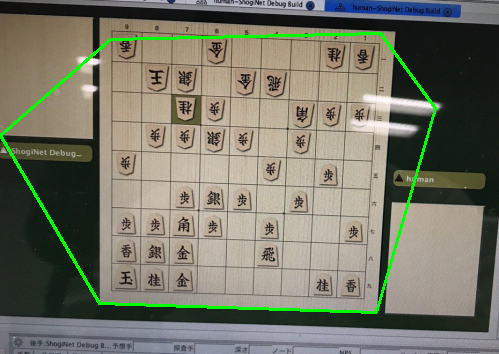

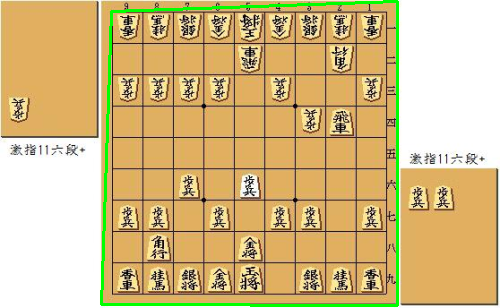

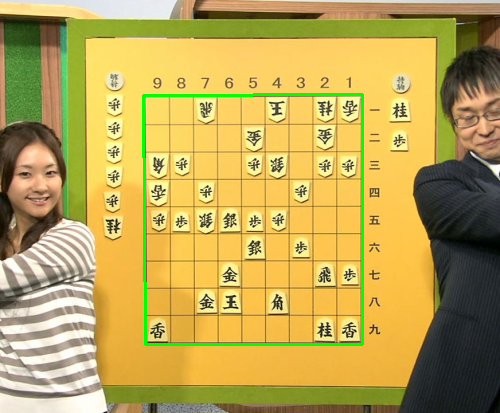

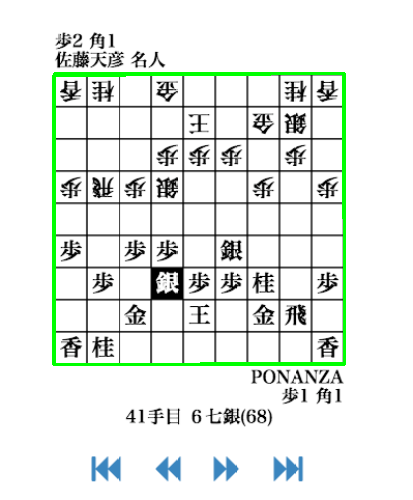

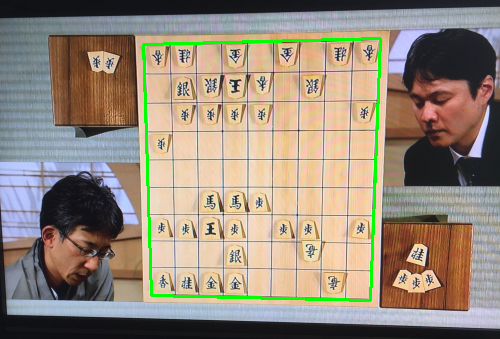

In [11]:
def convex_poly(img, show=True):
    cnts = convex(img, False)
    blank = np.copy(img)
    polies = []
    for cnt in cnts:
        arclen = cv2.arcLength(cnt, True)
        poly = cv2.approxPolyDP(cnt, 0.02*arclen, True)
        cv2.drawContours(blank, [poly], -1, (0,255,0), 2)
        polies.append(poly)
    if show:
        display_cv_image(blank)
    return [poly[:, 0, :] for poly in polies]

for img in imgs:
    convex_poly(img)

/usr/lib/python3/dist-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((180, 180), 255) will return an array of dtype('uint32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


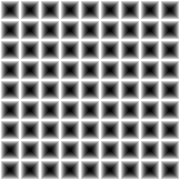

In [12]:
def gen_score_mat():
    half_a = np.fromfunction(lambda i, j: ((10 - i) ** 2) / 100.0, (10, 20), dtype=np.float32)
    half_b = np.rot90(half_a, 2)
    cell_a = np.r_[half_a, half_b]
    cell_b = np.rot90(cell_a)
    cell = np.maximum(cell_a, cell_b)
    return np.tile(cell, (9, 9))

score = gen_score_mat()
display_cv_image(score * np.full(score.shape, np.uint32(255)))

In [13]:
from scipy.optimize import basinhopping

def show_fitted(img, x):
    cntr = np.int32(x.reshape((4, 2)))
    blank = np.copy(img)
    cv2.drawContours(blank, [cntr], -1, (0,255,0), 2)
    display_cv_image(blank)

def get_get_fit_score(img, x):
    img_size = (img.shape[0] * img.shape[1]) ** 0.5
    
    # 線分化
    poly_length = cv2.arcLength(x, True)
    lines = line(img, False, int(poly_length / 20), int(poly_length / 160))
    line_mat = np.zeros(img.shape, np.uint8)
    for x1, y1, x2, y2 in lines[:, 0]:
        cv2.line(line_mat, (x1, y1), (x2, y2), 255, 1)
    line_mat = line_mat[:, :, 0]
    
    # 矩形の外をマスクアウト
    mask = np.zeros(line_mat.shape, np.uint8)
    cv2.fillConvexPoly(mask, x, 1)
    kernel = np.ones((int(img_size / 10), int(img_size // 10)), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=1)
    line_mat[np.where(mask == 0)] = 0
#     display_cv_image(line_mat)
    
    # スコア
    score_mat = gen_score_mat()

    def get_fit_score(x):
        img_pnts = np.float32(x).reshape(4, 2)
        score_size = score_mat.shape[0]
        score_pnts = np.float32([[0, 0], [0, score_size], [score_size, score_size], [score_size, 0]])

        transform = cv2.getPerspectiveTransform(score_pnts, img_pnts)
        score_t = cv2.warpPerspective(score_mat, transform, (img.shape[1], img.shape[0]))
        # display_cv_image(warped * np.full(warped.shape, np.uint8(255)))

        res = line_mat * score_t
        # display_cv_image(res)
        return -np.average(res[np.where(res > 255 * 0.1)])
    
    return get_fit_score

import itertools

def select_corners(img, polies):
    p_selected = []
    p_scores = []
    for poly in polies:
        choices = np.array(list(itertools.combinations(poly, 4)))
        scores = [get_get_fit_score(img, c)(c.flatten()) for c in choices]
        idx = np.argmin(scores)
        p_selected.append(choices[idx])
        p_scores.append(scores[idx])
    return p_selected[np.argmin(p_scores)]

def convex_poly_fitted(img, show=True):
    polies = convex_poly(img, False)
    poly = select_corners(img, polies)
    x0 = poly.flatten()
    get_fit_score = get_get_fit_score(img, poly)
    ret = basinhopping(get_fit_score, x0, T=0.1, niter=250, stepsize=3.0)
    if show:
        print(get_fit_score(x0))
#         show_fitted(img, x0)
        print(ret.fun)
        show_fitted(img, ret.x)
    return ret.x.reshape(4, 2), ret.fun

# rects = []
# for img in imgs:
#     rect, score = convex_poly_fitted(img)
#     rects.append(rect)

In [14]:
# 変数を左上・右下の点の座標, 点からの辺の角度にしてみた
# 精度出ず失敗
from scipy.optimize import basinhopping

def show_fitted(img, x):
    cntr = np.int32(x)
#     cntr = np.int32([[x[0],  x[1]], [x[2], x[3]], [x[4], x[5]], [x[6], x[7]]])
    blank = np.copy(img)
    cv2.drawContours(blank, [cntr], -1, (0,255,0), 2)
    display_cv_image(blank)

def intersection(a, b):
    a1 = a[0]
    a2 = np.array([a1[0] + 1, a1[1] + math.tan(a[1] / 80)])
    b1 = b[0]
    b2 = np.array([b1[0] + 1, b1[1] + math.tan(b[1] / 80)])
    return a1 + (a2 - a1) * np.cross(b2 - b1, b1 - a1) / np.cross(b2 - b1, a2 - a1)

def lines_to_points(lines):
    base1 = lines[0:2]
    base2 = lines[2:4]
    angle11 = lines[4]
    angle12 = lines[5]
    angle21 = lines[6]
    angle22 = lines[7]
    
    p1 = intersection([base1, angle11], [base2, angle21])
    p3 = intersection([base1, angle12], [base2, angle22])
    return np.float32([base1, p1, base2, p3])

def get_angle(a, b):
    return math.atan2(b[1] - a[1], b[0] - a[0]) * 80

def points_to_lines(points):
    base1 = np.float32(points[0])
    base2 = np.float32(points[2])
    angle11 = get_angle(points[0], points[1])
    angle12 = get_angle(points[0], points[3])
    angle21 = get_angle(points[2], points[1])
    angle22 = get_angle(points[2], points[3])
    
    return np.r_[base1, base2, np.float32([angle11, angle12, angle21, angle22])]
    
def get_get_fit_score(img, x):
    poly_length = cv2.arcLength(x, True)
    lines = line(img, False, int(poly_length / 20), int(poly_length / 160))
    line_mat = np.zeros(img.shape, np.uint8)
    for x1, y1, x2, y2 in lines[:, 0]:
        cv2.line(line_mat, (x1, y1), (x2, y2), 255, 1)
    line_mat = line_mat[:, :, 0]
    mask = np.zeros(line_mat.shape, np.uint8)
    cv2.fillConvexPoly(mask, x, 1)
    mask = cv2.erode(mask, np.ones((30, 30), np.uint8), iterations=1)
    line_mat[np.where(mask == 0)] = 0
    # display_cv_image(line_mat)
    score_mat = gen_score_mat()

    def get_fit_score(x):
        img_pnts = np.float32(lines_to_points(x))
        
        score_size = score_mat.shape[0]
        score_pnts = np.float32([[0, 0], [0, score_size], [score_size, score_size], [score_size, 0]])

        transform = cv2.getPerspectiveTransform(score_pnts, img_pnts)
        warped = cv2.warpPerspective(score_mat, transform, (img.shape[1], img.shape[0]))
        # display_cv_image(warped * np.full(warped.shape, np.uint8(255)))

        res = line_mat * warped
        # display_cv_image(res)
        return -np.average(res[np.where(res > 255 * 0.1)])
#         return -np.average(res) * 10
    
    return get_fit_score

import itertools

def select_corners(img, polies):
    p_selected = []
    p_scores = []
    for poly in polies:
        choices = np.array(list(itertools.combinations(poly, 4)))
        scores = []
        for c in choices:
            score = get_get_fit_score(img, c)(points_to_lines(c).flatten())
            scores.append(score)
        idx = np.argmin(scores)
        p_selected.append(choices[idx])
        p_scores.append(scores[idx])
    return p_selected[np.argmin(p_scores)]

def convex_poly_fitted(img, show=True):
    polies = convex_poly(img, False)
    polies = [poly[:, 0, :] for poly in polies]
    poly = select_corners(img, polies)
    x0 = points_to_lines(poly).flatten()
    get_fit_score = get_get_fit_score(img, poly)
    ret = basinhopping(get_fit_score, x0, T=0.5, niter=250, stepsize=2.0)
    if show:
#         print(get_fit_score(x0))
#         show_fitted(img, lines_to_points(x0).reshape(4, 2))
        print(ret.fun)
        show_fitted(img, lines_to_points(ret.x).reshape(4, 2))
    return lines_to_points(ret.x).reshape(4, 2), ret.fun

# rects = []
# for i in range(10):
#     for img in imgs[1:2]:
#         rect, score = convex_poly_fitted(img)
#         rects.append(rect)

-218.854
-227.751


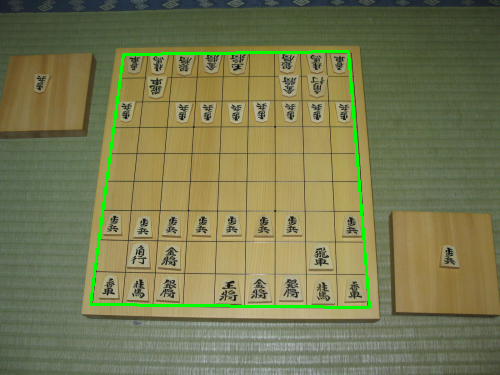

-172.525
-211.165


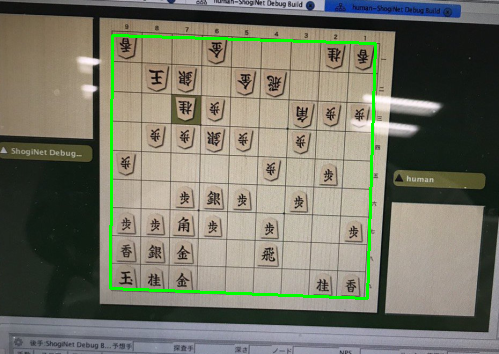

-191.845
-235.071


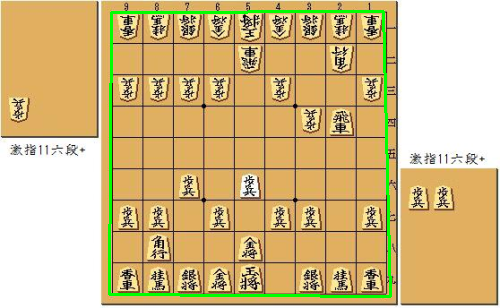

-203.16
-210.074


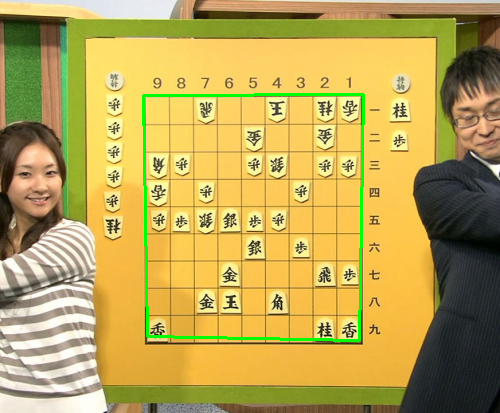

-234.09
-238.117


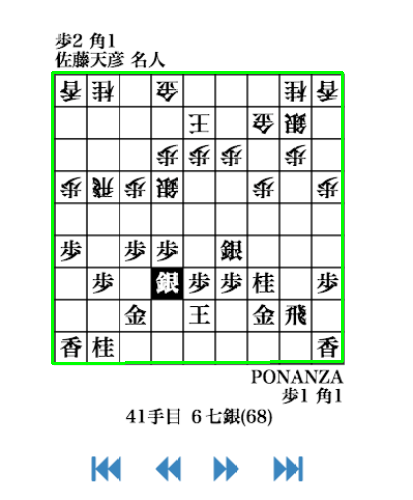

-199.478
-203.975


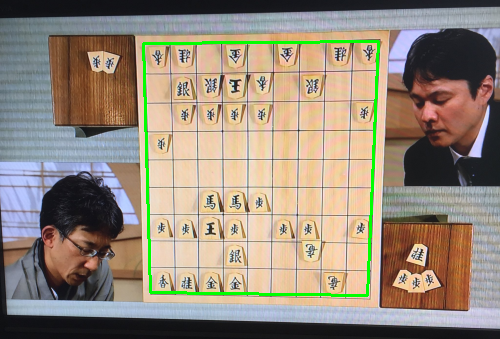

In [15]:
from scipy.optimize import basinhopping

def show_fitted(img, x):
    cntr = np.int32(x.reshape((4, 2)))
    blank = np.copy(img)
    cv2.drawContours(blank, [cntr], -1, (0,255,0), 2)
    display_cv_image(blank)

SCALE = 0.7
def get_get_fit_score(img, x):
    # 入力リサイズ
    img = cv2.resize(img, (int(img.shape[1] * SCALE), int(img.shape[0] * SCALE)), interpolation=cv2.INTER_AREA)
    img_size = (img.shape[0] * img.shape[1]) ** 0.5
    x = np.int32(x * SCALE)

    # 線分化
    poly_length = cv2.arcLength(x, True)
    lines = line(img, False, int(poly_length / 12), int(poly_length / 200))
    line_mat = np.zeros(img.shape, np.uint8)
    for x1, y1, x2, y2 in lines[:, 0]:
        cv2.line(line_mat, (x1, y1), (x2, y2), 255, 1)
    line_mat = line_mat[:, :, 0]
    
    # 矩形の外をマスクアウト
    img_size = (img.shape[0] * img.shape[1]) ** 0.5
    mask = np.zeros(line_mat.shape, np.uint8)
    cv2.fillConvexPoly(mask, x, 1)
    kernel = np.ones((int(img_size / 10), int(img_size / 10)), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=1)
    line_mat[np.where(mask == 0)] = 0
    
    # スコア
    score_mat = gen_score_mat()

    def get_fit_score(x):
        img_pnts = np.float32(x).reshape(4, 2)
        img_pnts *= SCALE
        score_size = score_mat.shape[0]
        score_pnts = np.float32([[0, 0], [0, score_size], [score_size, score_size], [score_size, 0]])

        transform = cv2.getPerspectiveTransform(score_pnts, img_pnts)
        score_t = cv2.warpPerspective(score_mat, transform, (img.shape[1], img.shape[0]))
        # display_cv_image(warped * np.full(warped.shape, np.uint8(255)))

        res = line_mat * score_t
        # display_cv_image(res)
        return -np.average(res[np.where(res > 255 * 0.1)])
    
    return get_fit_score

import itertools

def select_corners(img, polies):
    p_selected = []
    p_scores = []
    for poly in polies:
        choices = np.array(list(itertools.combinations(poly, 4)))
        scores = []
        # 正方形に近いものを選ぶ
        for c in choices:
            score = 0
            for i in range(4):
                a = c[(i + 1) % 4] - c[i]
                a = a / np.linalg.norm(a)
                b = c[(i + 2) % 4] - c[(i + 1) % 4]
                b = b / np.linalg.norm(b)
                score += abs(np.dot(a, b))
            scores.append(score)
        idx = np.argmin(scores)
        p_selected.append(choices[idx])
        p_scores.append(scores[idx])
    return p_selected[np.argmin(p_scores)]

def convex_poly_fitted(img, show=True):
    polies = convex_poly(img, False)
    poly = select_corners(img, polies)
    x0 = poly.flatten()
    get_fit_score = get_get_fit_score(img, poly)
    ret = basinhopping(get_fit_score, x0, T=0.1, niter=250, stepsize=3)
    if show:
        print(get_fit_score(x0))
#         show_fitted(img, x0)
        print(ret.fun)
        show_fitted(img, ret.x)
    return ret.x.reshape(4, 2), ret.fun

rects = []
for img in imgs:
    rect, score = convex_poly_fitted(img)
    rects.append(rect)

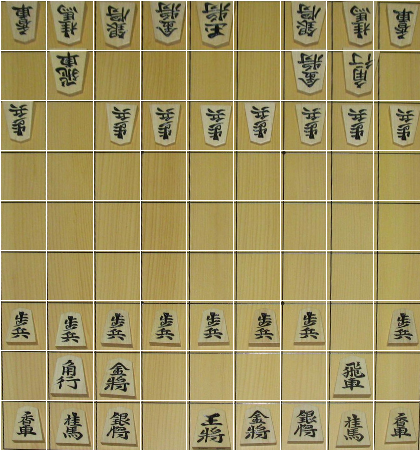

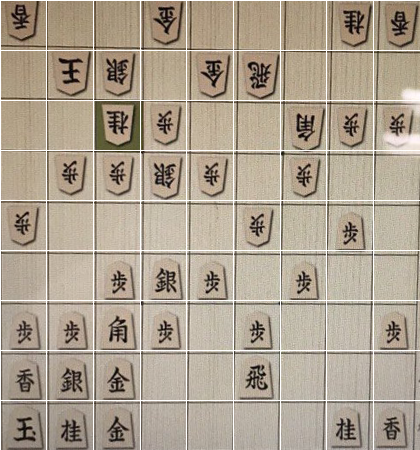

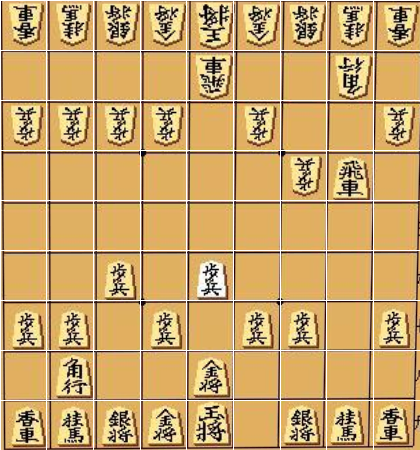

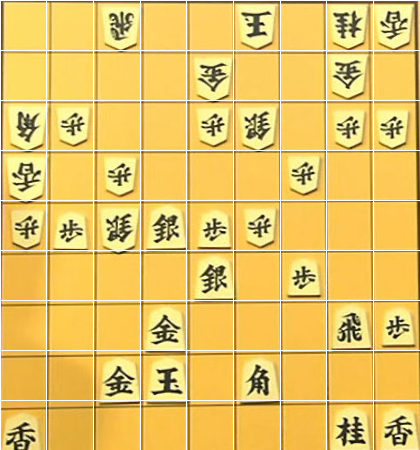

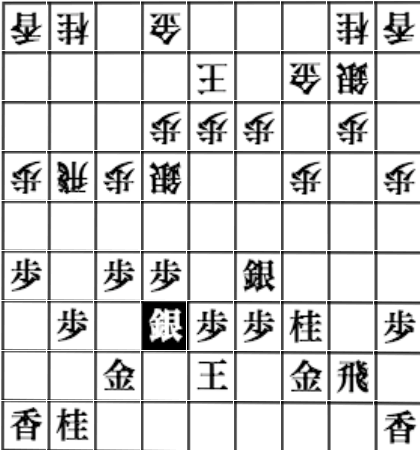

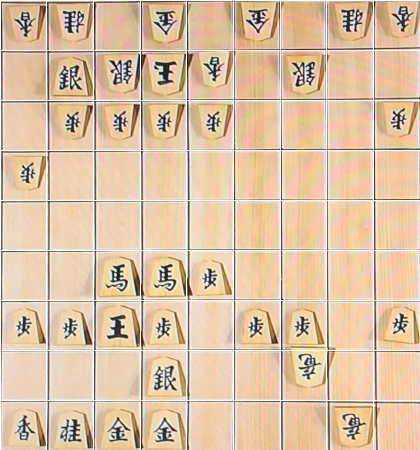

In [16]:
import math
def normalize_corners(v):
    rads = []
    for i in range(4):
        a = v[(i + 1) % 4] - v[i]
        a = a / np.linalg.norm(a)
        cosv = np.dot(a, np.array([1, 0]))
        rads.append(math.acos(cosv))
    left_top = np.argmin(rads)
    return np.roll(v, 4 - left_top, axis=0)

def trim(img, corners, show=True):
    transform = cv2.getPerspectiveTransform(np.float32(corners), np.float32([[0, 0], [30*14, 0], [30*14, 30*15], [0, 30*15]]))
    normed = cv2.warpPerspective(img, transform, (30*14, 30*15))
    if show:
        display_cv_image(normed)
    return normed

def draw_ruled_line(img, show=True):
    w = 30*14
    h = 30*15
    img = img.copy()
    for i in range(10):
        x = int((w / 9) * i)
        y = int((h / 9) * i)
        cv2.line(img, (x, 0), (x, h), (255, 255, 255), 1)
        cv2.line(img, (0, y), (w, y), (255, 255, 255), 1)
    if show:
        display_cv_image(img)
    return img

for i in range(len(imgs)):
    rect = normalize_corners(rects[i])
    img = trim(raw_imgs[i], rect * (raw_imgs[i].shape[0] / imgs[i].shape[0]), False)
    img = draw_ruled_line(img)
#     cv2.imwrite('images/normed/%d.png' % (i + 1), img)